# Report Showcase - Group 47

### Lingtian He, Zhenhao Chen, Tong Cheng

## Overall Project Objectives

The project is focused on the analysis of **CS:GO**(Counter Strike: Global Offensive), a popular first-person-shooting online video game. 

We have already compared the professional players and common players to see the different decisions they make under similar situation; computed the winning probability under each possible condition; finded the factors affecting the winning probability.

Overall, after analysis, we provided the useful strategies under different conditions, such as the buying strategies at the beginning of each round, and bombing planting strategies.

## Description of Data

The whole dataset contains the overall and detailed information of 14921 ESEA matches, and the data of map. 
The dataset of match is initially separated by 2 parts, and each part has the independent files of basic information data, damage data, grenade data and kill data. 

- [1] **Metadata** contains per round meta information. 
- [2] **Damage**'s each row documents is an event when a player is hurt by another player. 
- [3] **Grenade** contains a grenade thrown entry no matter whether the grenade causes damage.
- [4] **Kill**'s each row is a kill entry. 
- [5] **Map** includes 7 official radar maps, which specifies in-game coordinates to aid in mapping data over them. 

The dataset is obtained from Kaggle Dataset ‘CS:GO Competitive Matchmaking Data’. It can be found [here](https://www.kaggle.com/skihikingkevin/csgo-matchmaking-damage).

## Progress Demonstration (in code)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

 > ### Key examples of preprocessing data

The basic information as mentioned is in the file called 'esea_meta_demos'. In order to connect other data(damage, grenade and kill) with basic information of every match, we inner join the data on column 'file' and 'round'.
Since the whole dataset, all the matches, has been separated into part1 and part2, we have to combine them together.

In [3]:
#删掉
path='/Users/lyndon/Documents/BUDT 758X/Project/csgo/'

In [5]:
#删掉
meta_1=pd.read_csv(path+'esea_meta_demos.part1.csv')
meta_1=meta_1[meta_1.map=='de_dust2'] 
meta_2=pd.read_csv(path+'esea_meta_demos.part2.csv')
meta_2=meta_2[meta_2.map=='de_dust2']

kill_1=pd.read_csv(path+'esea_master_kills_demos.part1.csv')
kill_2=pd.read_csv(path+'esea_master_kills_demos.part2.csv')
dmg_1=pd.read_csv(path+'esea_master_dmg_demos.part1.csv')
dmg_2=pd.read_csv(path+'esea_master_dmg_demos.part2.csv')
grenade_1=pd.read_csv(path+'esea_master_grenades_demos.part1.csv')
grenade_2=pd.read_csv(path+'esea_master_grenades_demos.part2.csv')

In [6]:
#inner join the kill data with meta data
kill_1=meta_1.merge(kill_1, how='inner', on=['file','round'])
kill_2=meta_2.merge(kill_2, how='inner', on=['file','round'])
kill=pd.concat([kill_1, kill_2]) #concatenate part1 and part2

#inner join the damage data with meta data
dmg_1=meta_1.merge(dmg_1,how='inner',on=['file','round'])
dmg_2=meta_2.merge(dmg_2,how='inner',on=['file','round'])
dmg=pd.concat([dmg_1,dmg_2]) #concatenate part1 and part2

#inner join the grenade data with meta data
grenade_1=meta_1.merge(grenade_1,how='inner',on=['file','round'])
grenade_2=meta_2.merge(grenade_2,how='inner',on=['file','round'])
grenade=pd.concat([grenade_1,grenade_2]) #concatenate part1 and part2

In [7]:
#删掉！drop the useless column
kill.drop(['map','tick'], axis=1, inplace=True) 
dmg.drop(['map','tick','att_id','att_rank','vic_id','vic_rank'],axis=1,inplace=True) 
grenade.drop(['map','att_id','att_rank','vic_id','vic_rank'],axis=1,inplace=True) 

We also generate some other useful data from original dataset: 
   - [seconds] indicates the time in seconds at which the damage or grenade happens in each round in the dmg data and grenade data
   - [wp_side] indicates whether the weapon is only available for ct(Counter Terrorist) or for t(Terrorist) in the dmg data
   - [pro_game] indicates whether it is a pro game in the dmg data

In [8]:
#add a column called 'seconds' in each round from start time and end time 
dmg.seconds=dmg.seconds-dmg.start_seconds
grenade.seconds=grenade.seconds-grenade.start_seconds

In [9]:
#add a column called 'wp_side', which indicates whether it's a CT weapon or T weapon
keys=[i for i in dmg.wp.unique()]
ct_wp=['USP','P2000','FiveSeven','MP9','Famas','M4A4','M4A1','AUG','Scar20','Incendiary']
t_wp=['Glock','Tec9','Mac10','Gallil','AK47','SG556','G3SG1','SawedOff','Molotov']
values=['ct' if i in ct_wp else 't' if i in t_wp else 'both' for i in keys]
wp_map=dict(zip(keys,values))
dmg['wp_side']=dmg.wp.map(wp_map)

In [10]:
#add column 'pro_game' indicates if it's a pro game
dmg['pro_game']=dmg.att_team.apply(lambda x: 0 if x=='Team 1' or x=='Team 2' else 1)

Some values in columns are represented in different ways, so we unify them in one way for further use.

In [11]:
#convert negative number to postive, negative number meaning that how many people die
kill['ct_alive'][kill['ct_alive']<0]=kill['ct_alive'][kill['ct_alive']<0].apply(lambda x: x+5)
kill['t_alive'][kill['t_alive']<0]=kill['t_alive'][kill['t_alive']<0].apply(lambda x: x+5)

In [12]:
#删掉
dmg.bomb_site = dmg.bomb_site.fillna('Not Plant')

Create a dataframe for the analysis of the winning probability. After merging, we have 3 dataframes, but the information for what we need is diepersive and has to be collected, aggregated, and summarized. So we create a general dataframe including team wealth, winning side, type of round, time, bomb site, survivors.

In [13]:
#inner join the dataframe 'dmg' and 'kill'
round_infor=dmg.merge(kill, how='inner', on=['file','round'])
#delete all the duplicated rows for each round and keep the last row.
round_infor=round_infor.drop_duplicates(subset=['file','round'], keep='last')

#select useful columns for futher analaysis
round_infor=round_infor[['file', 'round', 'start_seconds_x', 'end_seconds_x', 'winner_team_x',
       'winner_side_x', 'round_type_x', 'ct_eq_val_x', 't_eq_val_x',
       'seconds_x','bomb_site','ct_alive', 't_alive']]

#rename the column name
round_infor=round_infor.rename(columns={'start_seconds_x': 'start_seconds', 'end_seconds_x':'end_seconds', 'winner_team_x':'winner_team',
       'winner_side_x':'winner_side', 'round_type_x':'round_type', 'ct_eq_val_x':'ct_eq_val', 't_eq_val_x':'t_eq_val',
       'seconds_x':'seconds'})
round_infor=round_infor.reset_index(drop=True)

In [14]:
round_infor.head()

,file,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,seconds,bomb_site,ct_alive,t_alive
0,esea_match_13779825.dem,1,131.3593,233.1502,Team 1,CounterTerrorist,PISTOL_ROUND,4400,3700,96.7507,Not Plant,3,0
1,esea_match_13779825.dem,2,233.1502,296.1376,Team 1,CounterTerrorist,ECO,18700,4050,57.9784,Not Plant,3,0
2,esea_match_13779825.dem,3,296.1376,373.3534,Team 1,CounterTerrorist,ECO,22100,1600,72.1756,Not Plant,4,1
3,esea_match_13779825.dem,4,373.3534,614.6275,Team 2,Terrorist,NORMAL,28250,20650,236.2496,B,0,2
4,esea_match_13779825.dem,5,614.6275,671.1659,Team 1,CounterTerrorist,FORCE_BUY,10250,21150,51.4981,Not Plant,2,0


> ### Analysis of the preprocessed data

### _The weapon preference of professonal players and common players_

In [15]:
#separate into two dfs: pro or not pro
dmg_common=dmg[dmg['pro_game']==0]
dmg_pro=dmg[dmg['pro_game']==1]

**1. weapon preference on general type**

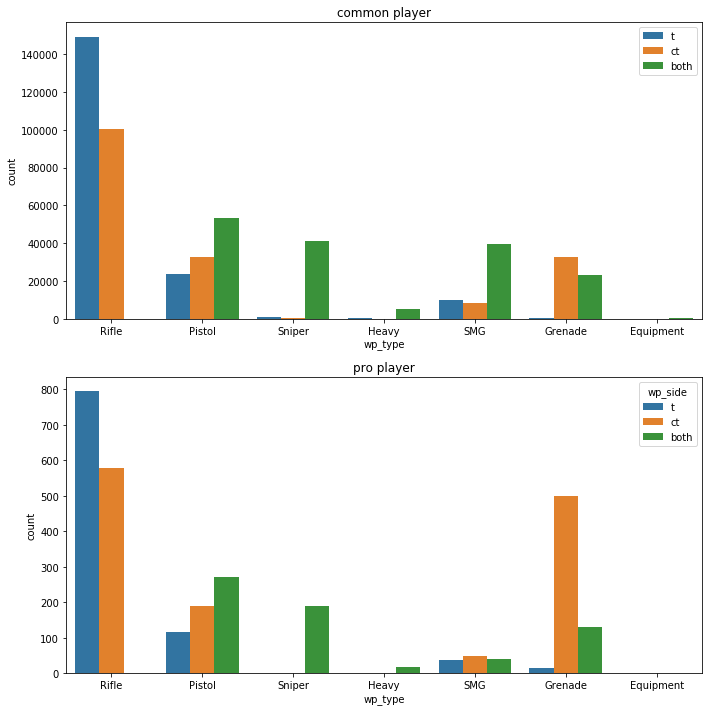

In [16]:
#future development:see https://matplotlib.org/gallery/pie_and_polar_charts/polar_bar.html#sphx-glr-gallery-pie-and-polar-charts-polar-bar-py
f,a=plt.subplots(2,1,figsize=(10,10))
sns.countplot(x='wp_type', data=dmg_common,ax=a[0],order=['Rifle','Pistol','Sniper','Heavy','SMG','Grenade','Equipment'],hue='wp_side',hue_order=['t','ct','both']).set_title('common player')
a[0].legend(loc='upper right')
sns.countplot(x='wp_type', data=dmg_pro,ax=a[1],order=['Rifle','Pistol','Sniper','Heavy','SMG','Grenade','Equipment'],hue='wp_side',hue_order=['t','ct','both']).set_title('pro player')
plt.tight_layout()

***Summary of the weapon preference of professonal players and common players on general type:***

- Pro players use grenade more often than common players. 
- Both common players and pro players have very similar preferences towards other weapon types.
- Rifle is the most popular type of weapon.

**2. weapon preference on detailed type**

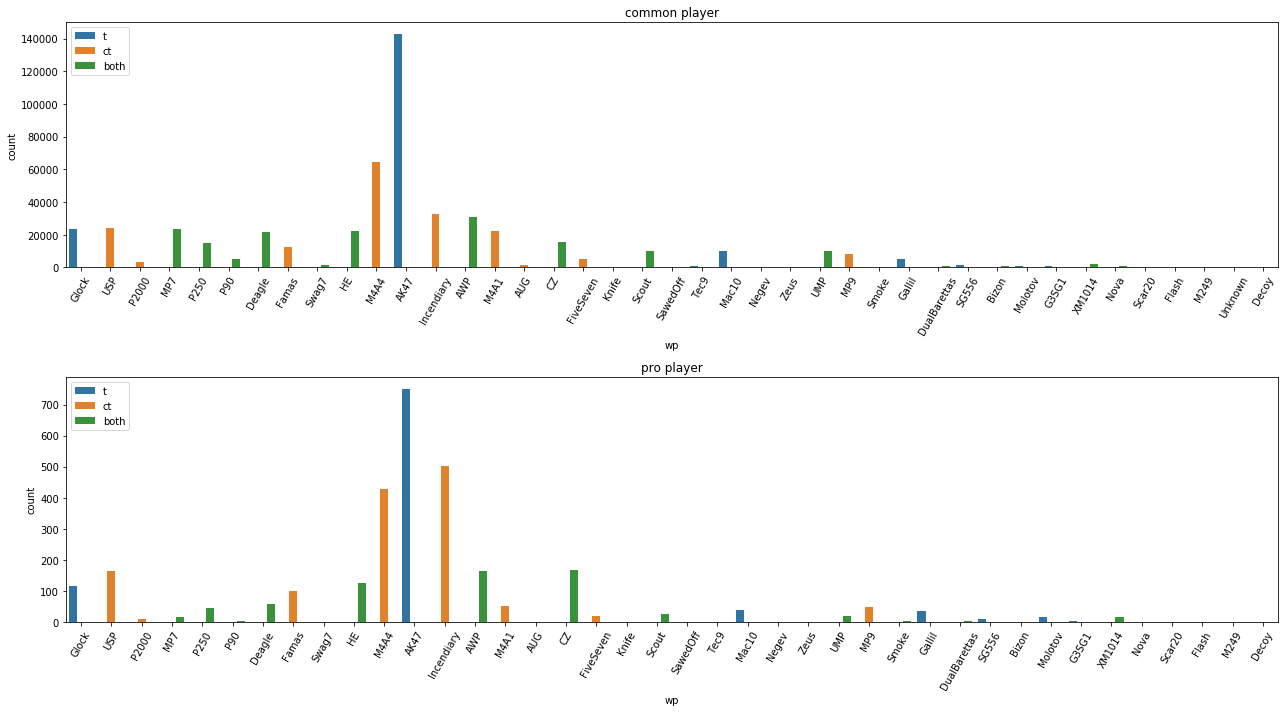

In [17]:
#weapon preference(detailed)
f,a=plt.subplots(2,1,figsize=(18,10))
g=sns.countplot(x='wp', data=dmg_common,ax=a[0],order=list(dmg_common.wp.unique()),hue='wp_side',hue_order=['t','ct','both'])
g.set_title('common player')
g.set_xticklabels(g.get_xticklabels(),rotation=60)
a[0].legend(loc='upper left')

#remove Unknown type for current use
col_use=list(dmg_common.wp.unique())
col_use.pop(col_use.index('Unknown'))
g=sns.countplot(x='wp', data=dmg_pro,ax=a[1],order=col_use,hue='wp_side',hue_order=['t','ct','both'])
g.set_title('pro player')
g.set_xticklabels(g.get_xticklabels(),rotation=60)
a[1].legend(loc='upper left')
plt.tight_layout()

***Summary of the weapon preference of professonal players and common players on detailed type:***

- Both common players and pro players would like to use AK47 and M4A4 frequently.
- But pro player would also equip incendiary more often than M4A4, since incendiary is a more strategic weapon.

**3. weapon preference on detailed type in each category without considering pro player and com player**

As we have analyzed the weapon preference on an overview of category and on the detailed weapon chosen, we would like to see the detailed weapon choosen in each category.

In [18]:
#weapon preference by category and detail type
wp_hier=dmg.set_index(['wp_type','wp'])
wp_hier_count=wp_hier.pivot_table(values=['round'],index=['wp_type','wp'],aggfunc='count')

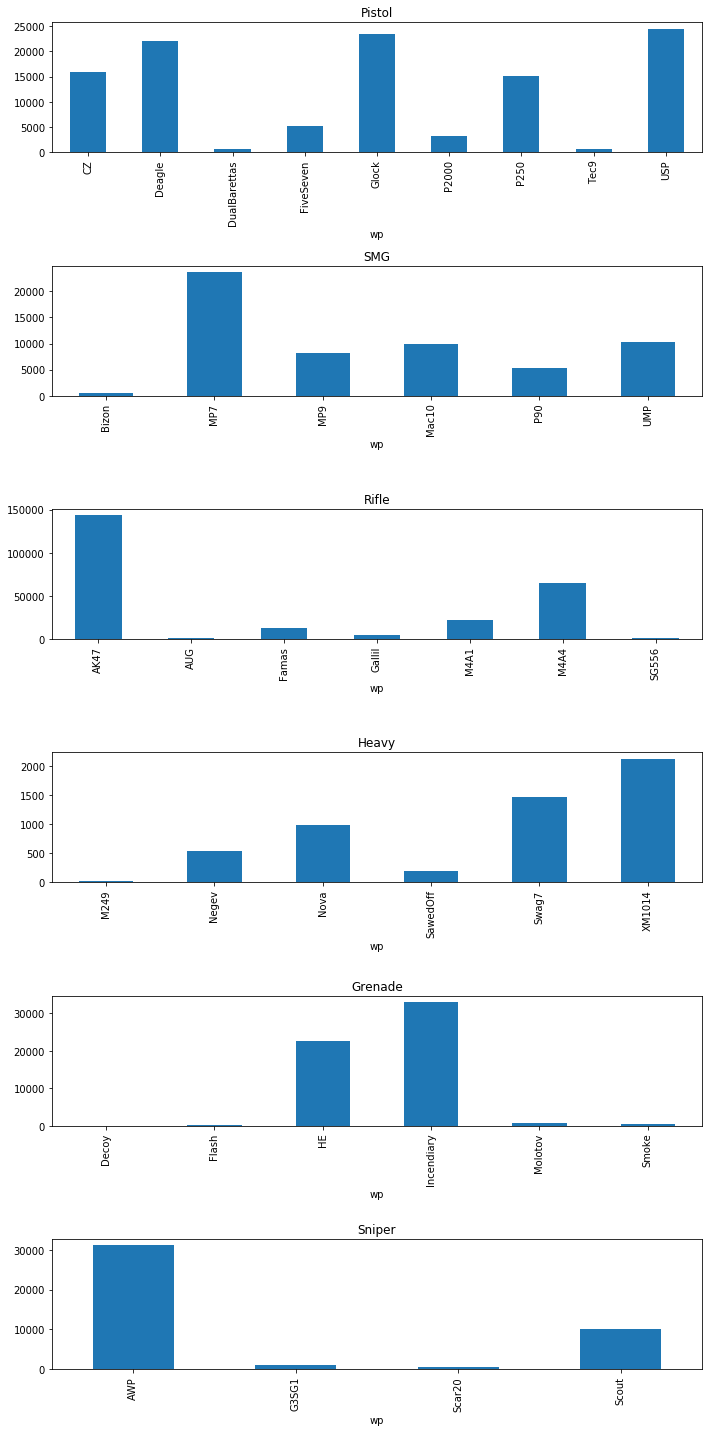

In [19]:
#preference by weapon category
f,a=plt.subplots(6,1,figsize=(10,20))
wp_hier_count.xs('Pistol').plot(kind='bar',ax=a[0],title='Pistol',legend=False)
wp_hier_count.xs('SMG').plot(kind='bar',ax=a[1],title='SMG',legend=False)
wp_hier_count.xs('Rifle').plot(kind='bar',ax=a[2],title='Rifle',legend=False)
wp_hier_count.xs('Heavy').plot(kind='bar',ax=a[3],title='Heavy',legend=False)
wp_hier_count.xs('Grenade').plot(kind='bar',ax=a[4],title='Grenade',legend=False)
wp_hier_count.xs('Sniper').plot(kind='bar',ax=a[5],title='Sniper',legend=False)
plt.tight_layout()

***Summary of the weapon preference of professonal players and common players on detailed type in each category:***

- For Pistol category, deagle, glock and USP is more popular, but DualBarettas and Tec9 are barely used.
- For SMG category, players preder to use MP7, but rarely choose Bizon.
- For Rifle category, AK47 is the most popular one, but AUG, SG556 and Gallil are almost never choosen.
- For Heavy category, XM1014 is more likely to be used, but M249 is least likely.
- For Grenade category, increndiary is relatively much popular.
- For Sniper category, players would like to choose AWP, insteady of G35G1 and scar20.

In depth, the higher popularity of these listed weapon maybe because of the ease of collimation, the large damage produced, the large amount of bullet equiped, cost-effective price, etc.

### _The hitbox comparison of professional players and common players_

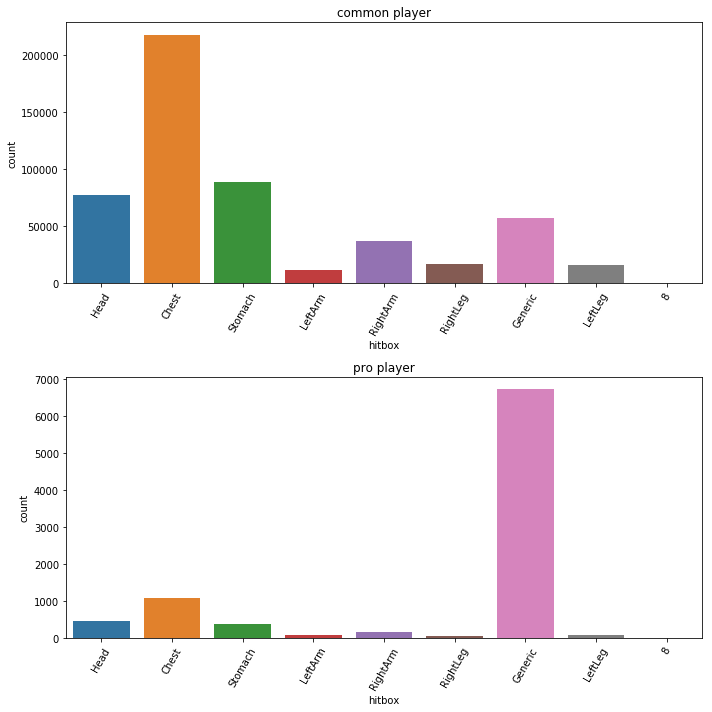

In [20]:
#hitbox analysis
f,a=plt.subplots(2,1,figsize=(10,10))
g=sns.countplot(x='hitbox', data=dmg_common,ax=a[0],order=list(dmg.hitbox.unique()))
g.set_title('common player')
g.set_xticklabels(g.get_xticklabels(),rotation=60)

g=sns.countplot(x='hitbox', data=dmg_pro,ax=a[1],order=list(dmg.hitbox.unique()))
g.set_title('pro player')
g.set_xticklabels(g.get_xticklabels(),rotation=60)
plt.tight_layout()

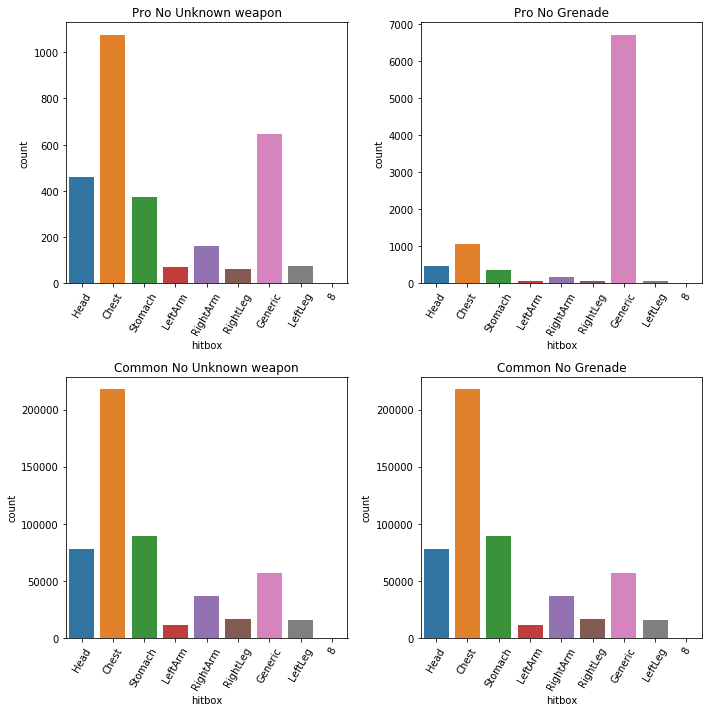

In [21]:
#exclude certain factors
f,a=plt.subplots(2,2,figsize=(10,10))
g=sns.countplot(x='hitbox', data=dmg_pro[dmg_pro['wp']!='Unknown'],ax=a[0,0],order=list(dmg.hitbox.unique()))
g.set_title('Pro No Unknown weapon')
g.set_xticklabels(g.get_xticklabels(),rotation=60)

g=sns.countplot(x='hitbox', data=dmg_pro[dmg_pro['wp']!='Grenade'],ax=a[0,1],order=list(dmg.hitbox.unique()))
g.set_title('Pro No Grenade')
g.set_xticklabels(g.get_xticklabels(),rotation=60)
plt.tight_layout()

g=sns.countplot(x='hitbox', data=dmg_common[dmg_common['wp']!='Unknown'],ax=a[1,0],order=list(dmg.hitbox.unique()))
g.set_title('Common No Unknown weapon')
g.set_xticklabels(g.get_xticklabels(),rotation=60)

g=sns.countplot(x='hitbox', data=dmg_common[dmg_common['wp']!='Grenade'],ax=a[1,1],order=list(dmg.hitbox.unique()))
g.set_title('Common No Grenade')
g.set_xticklabels(g.get_xticklabels(),rotation=60)
plt.tight_layout()

***Summary of the hitbox comparison of professional players and common players:***

- For common players, most of the time, they hit chest.
- For pro player, most of the time they hit generic. This is not expected. Generic the biggest part for pro player, even if grenade damage is excluded.

### _The winning probability affected by the site where bomb is planted, considering both CT side and T side_

In [22]:
#winning rate by bomb_site
dmg['map']='dust2'
bomb_win = dmg.groupby(['file', 'round', 'bomb_site', 'winner_side','map'])['start_seconds'].first().groupby(['map','bomb_site', 'winner_side']).count()
bomb_win_pct = bomb_win.groupby(level=[0,1]).apply(lambda x: 100 * x / float(x.sum()))
bomb_win_pct.unstack('map')

map                             dust2
bomb_site winner_side                
A         CounterTerrorist  20.836286
          Terrorist         79.163714
B         CounterTerrorist  19.679962
          Terrorist         80.320038
Not Plant CounterTerrorist  46.212121
          Terrorist         53.787879

***Summary of the winning probability affected by the site where bomb is planted, considering both CT side and T side:***

- If bomb is not planted, the chance of win is slightly higher for T.
- If bomb is planted, the chance of win for T increases by a huge percentage.

### _Heatmap_

In [23]:
# Position range of dust2 map
EndX=2127
EndY=3455
ResX=1024
ResY=1024
StartX=-2486
StartY=-1150

In [24]:
## Calculate revised position on map
# damage dataframe
dmg['att_pos_x']=ResX*(dmg['att_pos_x']-StartX)/(EndX-StartX)
dmg['att_pos_y']=ResY*(dmg['att_pos_y']-StartY)/(EndY-StartY)
dmg['vic_pos_x']=ResX*(dmg['vic_pos_x']-StartX)/(EndX-StartX)
dmg['vic_pos_y']=ResY*(dmg['vic_pos_y']-StartY)/(EndY-StartY)
# grenade dataframe
grenade['att_pos_x']=ResX*(grenade['att_pos_x']-StartX)/(EndX-StartX)
grenade['att_pos_y']=ResY*(grenade['att_pos_y']-StartY)/(EndY-StartY)
grenade['nade_land_x']=ResX*(grenade['nade_land_x']-StartX)/(EndX-StartX)
grenade['nade_land_y']=ResY*(grenade['nade_land_y']-StartY)/(EndY-StartY)
grenade['vic_pos_x']=ResX*(grenade['vic_pos_x']-StartX)/(EndX-StartX)
grenade['vic_pos_y']=ResY*(grenade['vic_pos_y']-StartY)/(EndY-StartY)

In [25]:
# Read background map image
dust2=plt.imread(path+'de_dust2.png')

In [29]:
# Heatmap function
def heatmap(image,plot1_series_x,plot1_series_y,plot2_series_x,plot2_series_y,title1,title2,c1='YlOrBr',c2='Blues'):
    fig,axes=plt.subplots(1,2,figsize=(18,16))
    axes[0].imshow(image, zorder=0, extent=[0, 1024, 0, 1024])
    axes[1].imshow(image, zorder=0, extent=[0, 1024, 0, 1024])
    axes[0].axis('off')
    axes[1].axis('off')

    a='CT'
    b='B'

    sns.kdeplot(plot1_series_x, plot1_series_y, cmap=c1, bw=15, ax=axes[0])
    axes[0].set_title(title1,fontsize=18)
    axes[0].axis((0,1024,0,1024))
    axes[0].annotate('B',xy=(180,850),fontsize=22,fontweight='bold',color='white')
    axes[0].annotate('A',xy=(800,800),fontsize=22,fontweight='bold',color='white')
    axes[0].annotate(f'{a:^10}\nSPAWN',xy=(550,760),fontsize=14,fontweight='bold',color='white')
    axes[0].annotate('T SPAWN',xy=(290,55),fontsize=14,fontweight='bold',color='white')
    axes[0].annotate('LONG A',xy=(850,650),fontsize=22,fontweight='bold',color='white',rotation=270)
    axes[0].annotate('MID',xy=(420,500),fontsize=22,fontweight='bold',color='white',rotation=270)
    axes[0].annotate(' LONG\nDOORS',xy=(660,380),fontsize=12,fontweight='bold',color='white',rotation=270)
    axes[0].annotate('UPPER B',xy=(100,510),fontsize=14,fontweight='bold',color='white')
    axes[0].annotate('CT MID',xy=(270,760),fontsize=22,fontweight='bold',color='white')
    axes[0].annotate('A PLAT',xy=(680,850),fontsize=14,fontweight='bold',color='white')
    axes[0].annotate(f'{b:^7}\nPLAT',xy=(60,850),fontsize=14,fontweight='bold',color='white')
    axes[0].annotate(f'DOOR\n{b:^9}',xy=(60,610),fontsize=14,fontweight='bold',color='white')
    axes[0].annotate('  MID\nDOOR',xy=(400,610),fontsize=12,fontweight='bold',color='white')

    sns.kdeplot(plot2_series_x, plot2_series_y, cmap=c2, bw=15, ax=axes[1])
    axes[1].set_title(title2,fontsize=18)
    axes[1].axis((0,1024,0,1024))
    axes[1].annotate('B',xy=(180,850),fontsize=22,fontweight='bold',color='white')
    axes[1].annotate('A',xy=(800,800),fontsize=22,fontweight='bold',color='white')
    axes[1].annotate(f'{a:^10}\nSPAWN',xy=(550,760),fontsize=14,fontweight='bold',color='white')
    axes[1].annotate('T SPAWN',xy=(290,55),fontsize=14,fontweight='bold',color='white')
    axes[1].annotate('LONG A',xy=(850,650),fontsize=22,fontweight='bold',color='white',rotation=270)
    axes[1].annotate('MID',xy=(420,500),fontsize=22,fontweight='bold',color='white',rotation=270)
    axes[1].annotate(' LONG\nDOORS',xy=(660,380),fontsize=12,fontweight='bold',color='white',rotation=270)
    axes[1].annotate('UPPER B',xy=(100,510),fontsize=14,fontweight='bold',color='white')
    axes[1].annotate('CT MID',xy=(270,760),fontsize=22,fontweight='bold',color='white')
    axes[1].annotate('A PLAT',xy=(680,850),fontsize=14,fontweight='bold',color='white')
    axes[1].annotate(f'{b:^7}\nPLAT',xy=(60,850),fontsize=14,fontweight='bold',color='white')
    axes[1].annotate(f'DOOR\n{b:^9}',xy=(60,610),fontsize=14,fontweight='bold',color='white')
    axes[1].annotate('  MID\nDOOR',xy=(400,610),fontsize=12,fontweight='bold',color='white')

**Attacking position heatmap during pistol round**

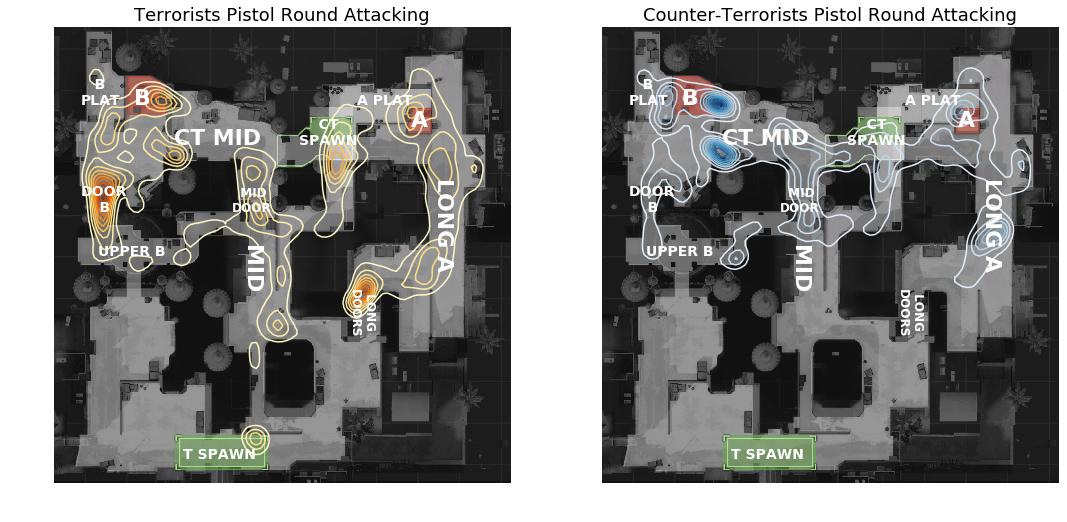

In [30]:
# Create 1X2 subplots
plot_df1 = dmg.loc[(dmg.att_side == 'Terrorist') & (dmg.round_type == 'PISTOL_ROUND')]
plot_df2 = dmg.loc[(dmg.att_side == 'CounterTerrorist') & (dmg.round_type == 'PISTOL_ROUND')]
heatmap(dust2,plot_df1['att_pos_x'],plot_df1['att_pos_y'],plot_df2['att_pos_x'],plot_df2['att_pos_y'],
        'Terrorists Pistol Round Attacking','Counter-Terrorists Pistol Round Attacking')

***Summary of attacking position heatmap during pistol round:***

These two graphs are attacking position heatmaps during pistol round. For a position on map, the denser the surrounding lines are, the more frequent attacks happen.  
Compared to overall attacking position heatmaps of all types of round, the distribution of attacking positions for terrorist side is more scattered while the distribution of counter-terrorist attacking position is more concentrative. Counter-terrorists have heavy preference on B side and the bottom left of CT Mid. Heavily attacking A side might be a wise choice for terrorists.

**Counter-Terrorists Attacking Bomb A heatmap**

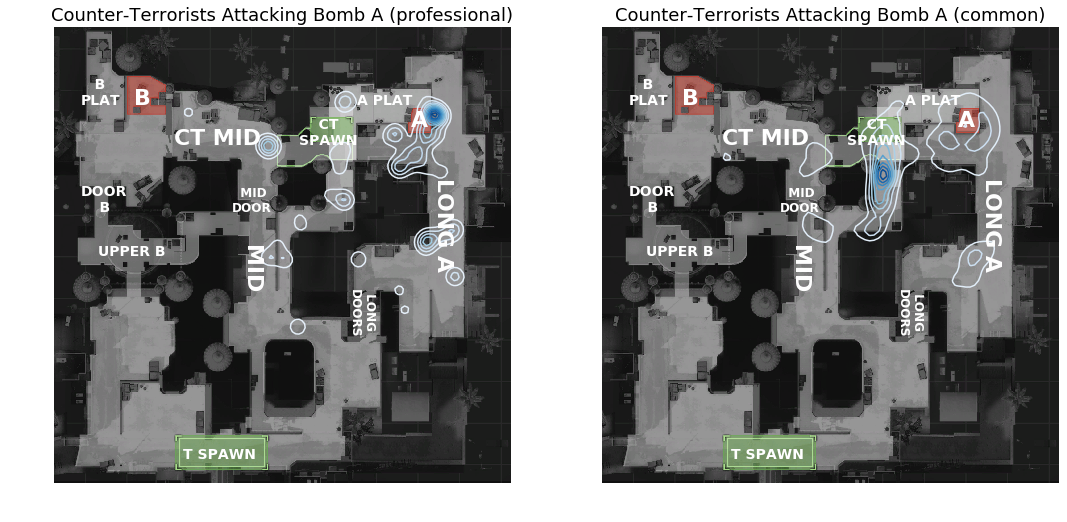

In [31]:
plot_df1 = dmg.loc[(dmg.att_side == 'CounterTerrorist') & (dmg.pro_game == 1) & (dmg.bomb_site == 'A')]
plot_df2 = dmg.loc[(dmg.att_side == 'CounterTerrorist') & (dmg.pro_game == 0) & (dmg.bomb_site == 'A')]
heatmap(dust2,plot_df1['att_pos_x'],plot_df1['att_pos_y'],plot_df2['att_pos_x'],plot_df2['att_pos_y'],
        'Counter-Terrorists Attacking Bomb A (professional)','Counter-Terrorists Attacking Bomb A (common)',c1='Blues')

***Summary of Counter-Terrorists Attacking Bomb A heatmap:***

These two graphs show how counter terrorists attack after the bomb is planted at A side. The left graph represents professional players and the right graph represents common players.
According to the heatmaps, professional and common players have different attacking strategies after the bomb is planted at A side. Professional players tend to attack from Long A while common players tend to attack from CT Spawn. But we can also notice that professional teams usually set a sniper at CT Mid. So actually they attack A side from two sides instead of one. Here is a situation that the tactics of professional teams and common teams differ.

### _winning probability under each round condition_

Analyze the winning probability under each round condition, conditions that include the round type(ECO, normal, etc), team-wealth, bombing or not, number of survivors;

In [32]:
round_infor.head()

,file,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,seconds,bomb_site,ct_alive,t_alive
0,esea_match_13779825.dem,1,131.3593,233.1502,Team 1,CounterTerrorist,PISTOL_ROUND,4400,3700,96.7507,Not Plant,3,0
1,esea_match_13779825.dem,2,233.1502,296.1376,Team 1,CounterTerrorist,ECO,18700,4050,57.9784,Not Plant,3,0
2,esea_match_13779825.dem,3,296.1376,373.3534,Team 1,CounterTerrorist,ECO,22100,1600,72.1756,Not Plant,4,1
3,esea_match_13779825.dem,4,373.3534,614.6275,Team 2,Terrorist,NORMAL,28250,20650,236.2496,B,0,2
4,esea_match_13779825.dem,5,614.6275,671.1659,Team 1,CounterTerrorist,FORCE_BUY,10250,21150,51.4981,Not Plant,2,0


In [50]:
round_infor['winner_side'].value_counts()['CounterTerrorist']/round_infor['winner_side'].value_counts().sum()

0.461557478368356

**Winning Probability vs Round Type and Bomb Site for ct and t**

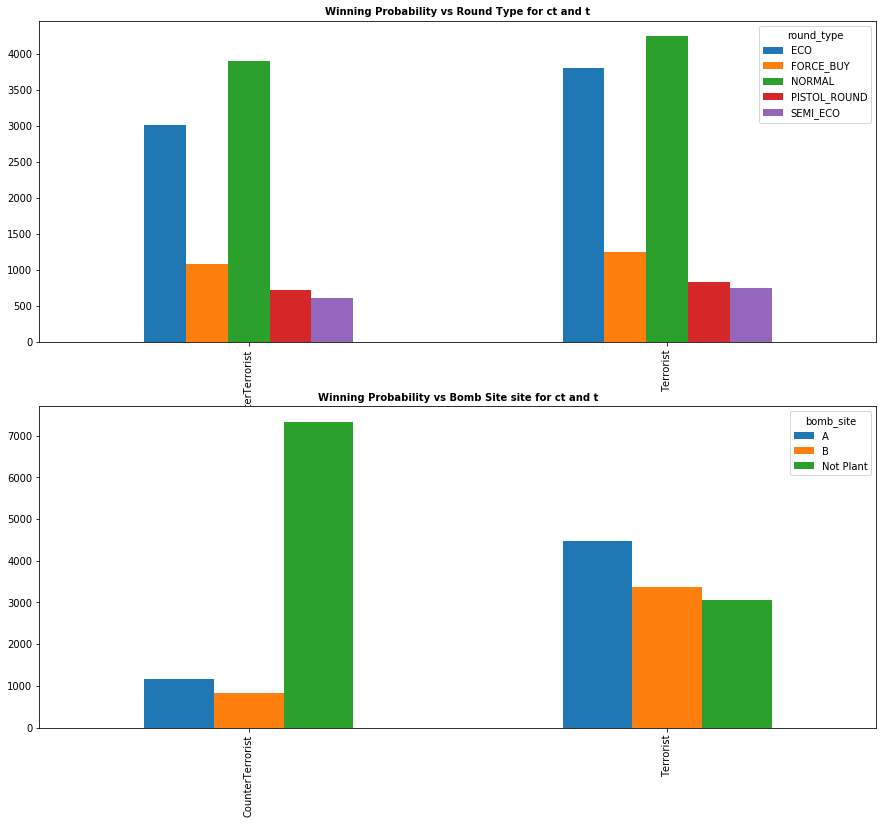

In [33]:
f, a = plt.subplots(2,1,figsize=(15,13))
pd.crosstab(index=round_infor.winner_side, columns=round_infor.round_type).loc[['CounterTerrorist','Terrorist']].plot(kind='bar',ax=a[0])
a[0].set_title('Winning Probability vs Round Type for ct and t', fontweight='bold', fontsize=10)
pd.crosstab(index=round_infor.winner_side, columns=round_infor.bomb_site).loc[['CounterTerrorist','Terrorist']].plot(kind='bar',ax=a[1])
a[1].set_title('Winning Probability vs Bomb Site site for ct and t', fontweight='bold', fontsize=10)
plt.xlabel('');

Summary of winning probability vs Round Type and Bomb Site for ct and t:

The first graph shows that if the round type is ECO and Normal, the terrorist has more probabilities to win this round, but for other types of round, the winning probabilities are quite similar. So terrorist has to seize the opportunity when it is a ECO or Normal round.

The second graph shows that when the bomb is planted either A or B, the terrorist team will have more probabilities to win, especially planting at site A. But, as you can see, bomb is not planted at all in many rounds, and the CounterTerrorist has more opportunities to win. So for terrorist, trying to plant bomb at site B is an important strategy to increase the winning probability.

**Winning Probability vs Team Wealth for ct and t**

Text(0.5, 0, 'Wealth Difference')

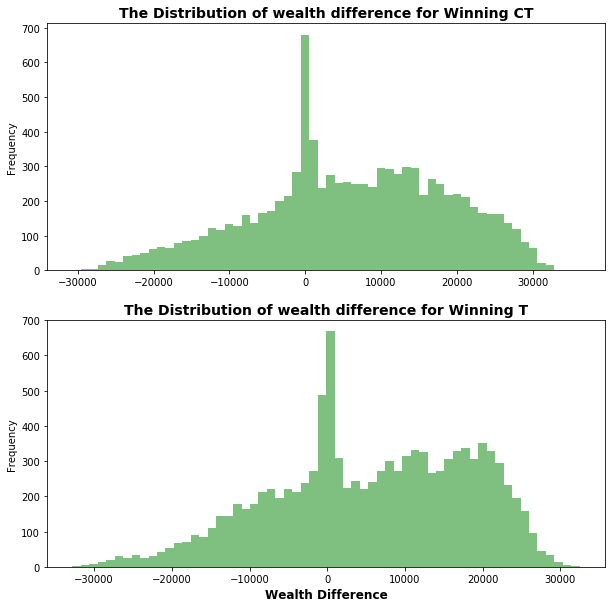

In [36]:

f, a = plt.subplots(2,1,figsize=(10,10))
wealthdiff_win_ct.plot.hist(bins=60, color='g', alpha=0.5, ax=a[0])
a[0].set_title('The Distribution of wealth difference for Winning CT', fontweight='bold', fontsize=14)
wealthdiff_win_t.plot.hist(bins=60, color='g', alpha=0.5, ax=a[1])
a[1].set_title('The Distribution of wealth difference for Winning T', fontweight='bold', fontsize=14)
a[1].set_xlabel('Wealth Difference', fontweight='bold', fontsize=12)

In [34]:
#calculate the wealth difference for different winning side(ct and t)
wealthdiff_win_ct=round_infor[round_infor['winner_side']=='CounterTerrorist']['ct_eq_val']-round_infor[round_infor['winner_side']=='CounterTerrorist']['t_eq_val']
wealthdiff_win_t=round_infor[round_infor['winner_side']=='Terrorist']['t_eq_val']-round_infor[round_infor['winner_side']=='Terrorist']['ct_eq_val']

Summary of Winning Probability vs Team Wealth for ct and t:


In [35]:
round_infor.head()

,file,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,seconds,bomb_site,ct_alive,t_alive
0,esea_match_13779825.dem,1,131.3593,233.1502,Team 1,CounterTerrorist,PISTOL_ROUND,4400,3700,96.7507,Not Plant,3,0
1,esea_match_13779825.dem,2,233.1502,296.1376,Team 1,CounterTerrorist,ECO,18700,4050,57.9784,Not Plant,3,0
2,esea_match_13779825.dem,3,296.1376,373.3534,Team 1,CounterTerrorist,ECO,22100,1600,72.1756,Not Plant,4,1
3,esea_match_13779825.dem,4,373.3534,614.6275,Team 2,Terrorist,NORMAL,28250,20650,236.2496,B,0,2
4,esea_match_13779825.dem,5,614.6275,671.1659,Team 1,CounterTerrorist,FORCE_BUY,10250,21150,51.4981,Not Plant,2,0


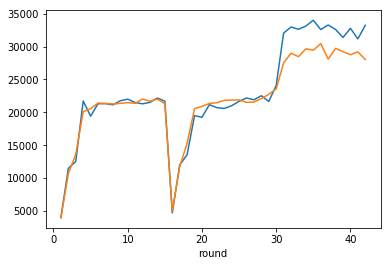

In [47]:
round_wealth=round_infor[['round','ct_eq_val','t_eq_val']].groupby('round').mean()
round_wealth
round_wealth['ct_eq_val'].plot()
round_wealth['t_eq_val'].plot()

In [51]:
#winning rate by round type
round_infor['map']='dust2'
roundtype_win = round_infor.groupby(['file', 'round', 'round_type', 'winner_side','map'])['start_seconds'].first().groupby(['map','round_type', 'winner_side']).count()
roundtype_win_pct = roundtype_win.groupby(level=[0,1]).apply(lambda x: 100 * x / float(x.sum()))
roundtype_win_pct.unstack('map')

map                                dust2
round_type   winner_side                
ECO          CounterTerrorist  44.224568
             Terrorist         55.775432
FORCE_BUY    CounterTerrorist  46.361301
             Terrorist         53.638699
NORMAL       CounterTerrorist  47.908232
             Terrorist         52.091768
PISTOL_ROUND CounterTerrorist  46.282051
             Terrorist         53.717949
SEMI_ECO     CounterTerrorist  44.837758
             Terrorist         55.162242

In [69]:
data=pd.DataFrame(roundtype_win_pct)
#plt.figure(figsize=(10,10))
#data = data.set_index(['round_type', 'winner_side']).value
data

start_seconds
map   round_type   winner_side                    
dust2 ECO          CounterTerrorist      44.224568
                   Terrorist             55.775432
      FORCE_BUY    CounterTerrorist      46.361301
                   Terrorist             53.638699
      NORMAL       CounterTerrorist      47.908232
                   Terrorist             52.091768
      PISTOL_ROUND CounterTerrorist      46.282051
                   Terrorist             53.717949
      SEMI_ECO     CounterTerrorist      44.837758
                   Terrorist             55.162242

## Conclusion

Moreover, we would analyze to identify the the factors that affect the winning probability, including the round type(ECO, normal, etc), scores, team-wealth, equipment and number of survivors, timing and positioning strategy.

Above all, we shall provide buying strategies at the beginning of each round, considering round type, scores, and team-wealth. After that, we will track one specific player's match data and provide targeted strategy advice. Besides, bombing planting strategies is also a part we will work on.